In [1]:
import pandas as pd
import os
import sys
import re
import json
import concurrent.futures
from tqdm import tqdm
import random
import pickle
from sklearn.model_selection import train_test_split
import torch
import pickle 

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
text_num_mapping_start = 2

sequence_augmentation = False
carsi_labels_only = True

PATH_TO_LOAD = '../data/04_Merged'

base_path = '../datasets/sequential/'
augmentation_folder = 'aug/' if sequence_augmentation else 'non_aug/'

parameter_path = f'{base_path}{augmentation_folder}parameters'
sequence_path = f'{base_path}{augmentation_folder}seq'


In [3]:
# def load_df(vehicle):
#     df = pd.read_csv(os.path.join(PATH_TO_LOAD, vehicle + "_merged.csv"), parse_dates=['datetime'], low_memory=False, index_col=0)
#     df = df.dropna(subset=['Label'])
#     df = df.sort_values(by=['session','datetime'])
#     df['full_label'] = df['Label'] + ' ' + df['FunctionValue']
#     return df

def load_df(vehicle):
    df = pd.read_csv(os.path.join(PATH_TO_LOAD, vehicle + "_merged.csv"), parse_dates=['datetime'], low_memory=False, index_col=0)
    df = df.dropna(subset=['Label'])
    df = df.sort_values(by=['session', 'datetime'])
    if carsi_labels_only:
        df['full_label'] = df['Label']
    else:
        mask = df['Label'] == 'navi/Start/Address'
        df.loc[mask, 'FunctionValue'] = 'a'
        df['full_label'] = df['Label'] + ' ' + df['FunctionValue']
    return df

full_df = pd.DataFrame()

vehicles = ['SEB880','SEB882','SEB883','SEB885','SEB888','SEB889']
# for vehicle in tqdm(vehicles):
#     df_curr = load_df(vehicle)
#     df_curr['vehicle'] = vehicle
#     df_curr = df_curr.dropna(subset=['full_label'])
#     full_df = pd.concat([full_df, df_curr], ignore_index=True)

def process_vehicle(vehicle):
    df_curr = load_df(vehicle)
    df_curr['vehicle'] = vehicle
    df_curr = df_curr.dropna(subset=['full_label'])
    return df_curr

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_vehicle, vehicles), total=len(vehicles)))

full_df = pd.concat(results, ignore_index=True)

mapping = {category: index + text_num_mapping_start for index, category in enumerate(full_df['full_label'].unique())}
full_df['full_label_num'] = full_df['full_label'].replace(mapping)

mapping_vehicle = {category: index + text_num_mapping_start for index, category in enumerate(full_df['vehicle'].unique())}
full_df['vehicle_num'] = full_df['vehicle'].replace(mapping_vehicle)

check = full_df.copy()
filt_df = full_df[['session','full_label_num','vehicle_num', 'datetime']].sort_values(by = ['session', 'datetime'])
filt_df = filt_df.drop_duplicates()

filt_df['interaction_time_delta'] = (filt_df.groupby('session')['datetime'].diff().dt.total_seconds()/60).round(1)
filt_df['interaction_time_delta'] = filt_df['interaction_time_delta'].fillna(0)
filt_df['interaction_time_delta']   = filt_df['interaction_time_delta'].astype(int)

100%|██████████| 6/6 [00:29<00:00,  4.88s/it]


28


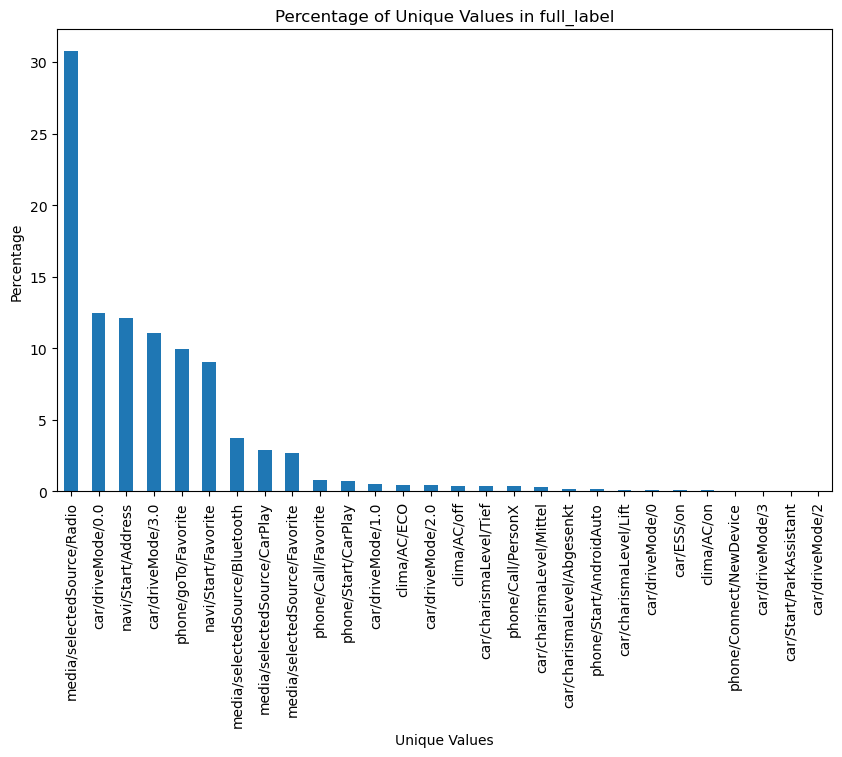

In [4]:
print(len(check['Label'].unique().tolist()))

import matplotlib.pyplot as plt

# Assuming your DataFrame is named full_df
value_counts = check['Label'].value_counts(normalize=True) * 100

# Plotting the bar chart
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Percentage of Unique Values in full_label')
plt.xlabel('Unique Values')
plt.ylabel('Percentage')
plt.show()


In [5]:
# To do add those session with just one interactions. that one interaction can the target and input sequence can be no click along with the context
# find session with just one interactions
session_counts = filt_df['session'].value_counts()
session_with_one_interactions = session_counts[session_counts == 1].index.tolist()
one_interactions = filt_df[filt_df['session'].isin(session_with_one_interactions)]

In [6]:
relevanat_df = filt_df[~filt_df['session'].isin(session_with_one_interactions)]
len(relevanat_df.session.unique().tolist())
# this is used to generate the appropriate context file
relevanat_df[['session', 'datetime']].to_csv(os.path.join(parameter_path, 'sequence_context.csv'))

In [7]:
## Generating augmented data
def explode_both(row):
        sequences = row['sequence']
        time_deltas = row['time_delta']
        sessions = [row['session']] * len(sequences)
        return pd.DataFrame({'session': sessions, 'sequence': sequences, 'time_delta': time_deltas})

def sequence_generation(df, sequence_augmentation):
    sequence_dict = {
        'session': [],
        'sequence': [],
        'time_delta': []
    }
    if sequence_augmentation == True:
        for session in df['session'].unique().tolist():
            check_df = df[df['session']== session]

            sequence_list = []
            time_delta_list = []
            seq_length = len(check_df)
            sequence = check_df['full_label_num'].tolist()
            time_delta = check_df['interaction_time_delta'].tolist()
            # print(session)
            # print(seq_length)
            # print(sequence)
            # print(time_delta)
            while seq_length != 1:
                sequence_list.append(sequence)
                time_delta_list.append(time_delta)
                # print(sequence_list)
                # print(time_delta_list)
                time_delta = time_delta[:-1]
                sequence = sequence[:-1]
                seq_length = seq_length -1
            sequence_dict['session'].append(session)
            sequence_dict['sequence'].append(sequence_list)
            sequence_dict['time_delta'].append(time_delta_list)
        sequence_df = pd.DataFrame(sequence_dict)
        sequence_df = pd.concat(sequence_df.apply(explode_both, axis=1).tolist(), ignore_index=True)
    else:
        for session in df['session'].unique().tolist():
            check_df = df[df['session']== session]
            
            if len(check_df) == 1:
                 continue
            sequence_list = []
            time_delta_list = []
            seq_length = len(check_df)
            sequence = check_df['full_label_num'].tolist()
            time_delta = check_df['interaction_time_delta'].tolist()
            
            sequence_dict['session'].append(session)
            sequence_dict['sequence'].append(sequence)
            sequence_dict['time_delta'].append(time_delta)
        sequence_df = pd.DataFrame(sequence_dict)

    return sequence_df

test_df = test_df = filt_df.drop(columns=['datetime', 'vehicle_num'])
df_exploded = sequence_generation(test_df, sequence_augmentation)

df_exploded['time_delta_list'] = df_exploded['time_delta'].apply(lambda x: x[1:] if isinstance(x, list) and len(x) > 1 else x)
df_exploded['interaction_time_delta_train'] = df_exploded['time_delta_list'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)
df_exploded['item_id_seq_train'] = df_exploded['sequence'].apply(lambda x: ' '.join(map(str, x[:-1])) if isinstance(x, list) and len(x) > 1 else None)
df_exploded['item_id_target'] = df_exploded['sequence'].apply(lambda x: x[-1] if isinstance(x, list) and len(x) > 0 else None)
df_exploded = df_exploded.dropna(subset=['item_id_target'])
df_exploded['item_id_target'] = df_exploded['item_id_target'].astype(int)
df_exploded = df_exploded.drop(columns=['sequence', 'time_delta', 'time_delta_list'])

In [8]:
if sequence_augmentation == True:
      total_sessions = df_exploded.session.unique().tolist()
      test_sessions, train_sessions = train_test_split(total_sessions, test_size=0.8, shuffle=True, random_state=42)
      train_df = df_exploded[df_exploded['session'].isin(train_sessions)].sort_index()
      test_df = df_exploded[df_exploded['session'].isin(test_sessions)].sort_index()
else:
      train_df, test_df = train_test_split(df_exploded, test_size=0.2, shuffle=True, random_state=42)
      train_df = train_df.sort_index()
      test_df = test_df.sort_index()
      train_sessions = train_df['session'].unique().tolist()
      test_sessions = test_df['session'].unique().tolist()

with open(os.path.join(parameter_path, 'train_sessions.pkl'), 'wb') as pickle_file:
        pickle.dump(train_sessions, pickle_file)

with open(os.path.join(parameter_path, 'test_sessions.pkl'), 'wb') as pickle_file:
        pickle.dump(test_sessions, pickle_file)

# train_df = train_df.sort_values(by='session')
# test_df = test_df.sort_values(by='session')

train_df = train_df.drop(['session'], axis=1)
test_df = test_df.drop(['session'], axis=1)

test_df['session_id'] = range(len(test_df))
test_df['session_id'] = test_df['session_id'].astype(int)

train_df['session_id'] = range(len(train_df))
train_df['session_id'] = train_df['session_id'].astype(int)

train_df = train_df[['session_id', 'item_id_seq_train', 'item_id_target', 'interaction_time_delta_train']]
test_df = test_df[['session_id', 'item_id_seq_train', 'item_id_target', 'interaction_time_delta_train']]

test_df.to_csv(os.path.join(sequence_path, 'test.tsv'), sep='\t', index=False)
train_df.to_csv(os.path.join(sequence_path, 'train.tsv'), sep='\t', index=False)

In [9]:
train_df

,session_id,item_id_seq_train,item_id_target,interaction_time_delta_train
0,0,3 2 3,3,10 21 19
1,1,3 2,3,10 21
2,2,3,2,10
4,3,5,6,0
5,4,5,6,0
...,...,...,...,...
5447,4421,3 5,6,23 0
5448,4422,3,5,23
5449,4423,6,7,0
5450,4424,8,16,8


In [10]:
file_path = os.path.join(sequence_path, 'train.tsv')
train_data = pd.read_csv(file_path, sep='\t')

def compute_class_weights(data):
    labels = torch.tensor(data.item_id_target)
    class_count = torch.bincount(labels)
    total_samples = len(labels)
    epsilon = 1e-5
    class_weights = 1.0 / ((class_count.float()) / total_samples)
    small_value = 1e-5
    class_weights[torch.isinf(class_weights)] = small_value
    # class_weights = torch.where(torch.isinf(class_weights), torch.tensor(0.0), class_weights)
    sum_weights = torch.sum(class_weights)
    class_weights = class_weights / sum_weights
    return class_weights

class_weights = compute_class_weights(train_data)

with open(os.path.join(parameter_path, 'param.pkl'), 'wb') as f:
        pickle.dump(class_weights, f)

class_weights

tensor([7.3215e-10, 7.3215e-10, 2.1460e-03, 2.8702e-04, 2.3313e-03, 9.4475e-04,
        5.5678e-04, 8.4168e-04, 4.0761e-04, 2.4927e-02, 9.5308e-03, 7.3215e-10,
        1.2463e-02, 4.0506e-02, 2.4927e-02, 3.6005e-02, 6.1841e-04, 5.4008e-02,
        1.6202e-02, 5.4008e-02, 1.4729e-02, 1.6202e-01, 7.3215e-10, 3.2405e-01,
        7.2011e-03, 1.3502e-02, 1.4729e-02, 1.8003e-02, 1.6202e-01, 3.0285e-03])